In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ecephys.sglx_utils import load_timeseries
from ecephys.signal.csd import get_kcsd
from ecephys.utils import find_nearest
from ecephys_analyses.data import channel_groups, paths

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from kcsd import KCSD1D
from scipy.signal import find_peaks
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

In [4]:
def get_csd(sig, params):
    k = get_kcsd(
        sig.values,
        intersite_distance=params["intersite_distance"],
        gdx=params["gdx"],
        lambd=params["lambd"],
        R_init=params["R"],
        do_lcurve=False,
    )
    est_csd = k.values('CSD')
    
    return xr.DataArray(
        est_csd,
        dims=("channel", "time"),
        coords={"channel": sig.channel.values, "time": sig.time.values},
        attrs={'units': "nA/mm", 'fs': sig.fs}
    )

In [5]:
def plot_epoched_profile(da, figsize=(36, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(da, xticklabels=da.time.values.round(), yticklabels=da.channel.values, cbar=False)
    ax.set(xticks=ax.get_xticks()[::2], yticks=ax.get_yticks()[::4], xlabel='Epoch center time (s)', ylabel='Channel')

In [6]:
def plot_profile(da, figsize=(36, 5), ylabel=None, negative_peaks=False):
    fig, ax = plt.subplots(figsize=figsize)
    channel_indices = np.arange(len(da.channel))
    sns.barplot(x=channel_indices, y=da, color='steelblue', ax=ax)
    ax.set(xlabel="Channel", ylabel=ylabel)
    ax.set_xticks(channel_indices);
    ax.set_xticklabels(da.channel.values, rotation=90);
    
    if negative_peaks:
        peaks, _ = find_peaks(-da.values, prominence=1000, distance=10)
    else:
        peaks, _ = find_peaks(da.values, prominence=1000, distance=10)
    sns.scatterplot(x=peaks, y=da.values[peaks], marker='x', color='red', ax=ax)

In [7]:
def create_report(csd, epoch_length, pdf_path):
    
    epoched_csd_nadirs = csd.coarsen(time=int(csd.fs *epoch_length), boundary='trim', coord_func={"time": "min"}).min()
    epoched_csd_variance = csd.coarsen(time=int(csd.fs *epoch_length), boundary='trim', coord_func={"time": "min"}).var()
    
    pdf_path = pdf_path.parent / (pdf_path.stem + f'-{epoch_length}s' + pdf_path.suffix)
    with PdfPages(pdf_path) as pdf:
        plot_epoched_profile(epoched_csd_variance)
        plt.title(f'CSD variance, {epoch_length}s epochs')
        pdf.savefig()
        plt.close()
        
        plot_epoched_profile(-epoched_csd_nadirs)
        plt.title(f'CSD nadirs, {epoch_length}s epochs')
        pdf.savefig()
        plt.close()

        for epoch in range(epoched_csd_nadirs.shape[1]):
            plot_profile(epoched_csd_variance[:, epoch], ylabel="CSD variance")
            plt.title(f'CSD variance, epoch: {epoch}, time: {epoched_csd_nadirs.time.values[epoch]}s')
            pdf.savefig()
            plt.close()
            
            plot_profile(epoched_csd_nadirs[:, epoch], ylabel="Deepest CSD sink (mA/mm)", negative_peaks=True)
            plt.title(f'CSD nadirs, epoch: {epoch}, time: {epoched_csd_nadirs.time.values[epoch]}s')
            pdf.savefig()
            plt.close()

        d = pdf.infodict()
        d['Title'] = f'{pdf_path.stem}'
        d['Author'] = 'Graham Findlay'
        d['Subject'] = 'CSD nadir profiles for tracking CA1 drift'
        d['CreationDate'] = datetime.now()

In [8]:
def create_reports(bin_path, pdf_path, chans, csd_params):
    sig = load_timeseries(bin_path, chans)
    csd = get_csd(sig, csd_params)
    
    create_report(csd, 600, pdf_path)
    create_report(csd, 300, pdf_path)
    create_report(csd, 60, pdf_path)

In [9]:
subject = "Segundo"

In [ ]:
drift_tracking_chans = channel_groups.drift_tracking[subject]
csd_params_path = paths.get_datapath(subject=subject, condition="sleep-homeostasis", file="sharp_wave_detection_params.json")
with open(csd_params_path) as csd_params_file:
    csd_params = json.load(csd_params_file)

bin_paths = paths.get_sglx_style_datapaths(subject=subject, condition="all", ext="lf.bin")
pdf_paths = paths.get_sglx_style_datapaths(subject=subject, condition="all", ext="CSD_SR_markers.pdf")

for bin_path, pdf_path in zip(bin_paths, pdf_paths):
    create_reports(bin_path, pdf_path, drift_tracking_chans, csd_params)
    current_time = datetime.now().strftime("%H:%M:%S")
    print(f"{current_time}: Finished {str(bin_path)}")

nChan: 385, nFileSamp: 18000000
17:52:45: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX2-Segundo/1-21-2020/1-21-2020_g0/1-21-2020_g0_imec0/1-21-2020_g0_t8.imec0.lf.bin
nChan: 385, nFileSamp: 18000000
18:01:03: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX2-Segundo/1-21-2020/1-21-2020_g0/1-21-2020_g0_imec0/1-21-2020_g0_t9.imec0.lf.bin
nChan: 385, nFileSamp: 18000000
18:09:15: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX2-Segundo/1-21-2020/1-21-2020_g0/1-21-2020_g0_imec0/1-21-2020_g0_t10.imec0.lf.bin
nChan: 385, nFileSamp: 18000000
18:17:45: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX2-Segundo/1-21-2020/1-21-2020_g0/1-21-2020_g0_imec0/1-21-2020_g0_t11.imec0.lf.bin
nChan: 385, nFileSamp: 18000000


# Debugging

In [11]:
drift_tracking_chans = channel_groups.drift_tracking[subject]
chans = drift_tracking_chans

csd_params_path = paths.get_datapath(subject=subject, condition="sleep-homeostasis", file="sharp_wave_detection_params.json")
with open(csd_params_path) as csd_params_file:
    csd_params = json.load(csd_params_file)

bin_paths = paths.get_sglx_style_datapaths(subject=subject, condition="recovery-sleep-2h", ext="lf.bin")
pdf_paths = paths.get_sglx_style_datapaths(subject=subject, condition="recovery-sleep-2h", ext="CSD-drift.pdf")

sig = load_timeseries(bin_paths[0], chans, start_time=0, end_time=60)
csd = get_csd(sig, csd_params)

nChan: 385, nFileSamp: 18000000


In [18]:
epoch_length = 20
epoched_csd_nadirs = csd.coarsen(time=int(epoch_length * csd.fs), coord_func={"time": "min"}, boundary='trim').min()

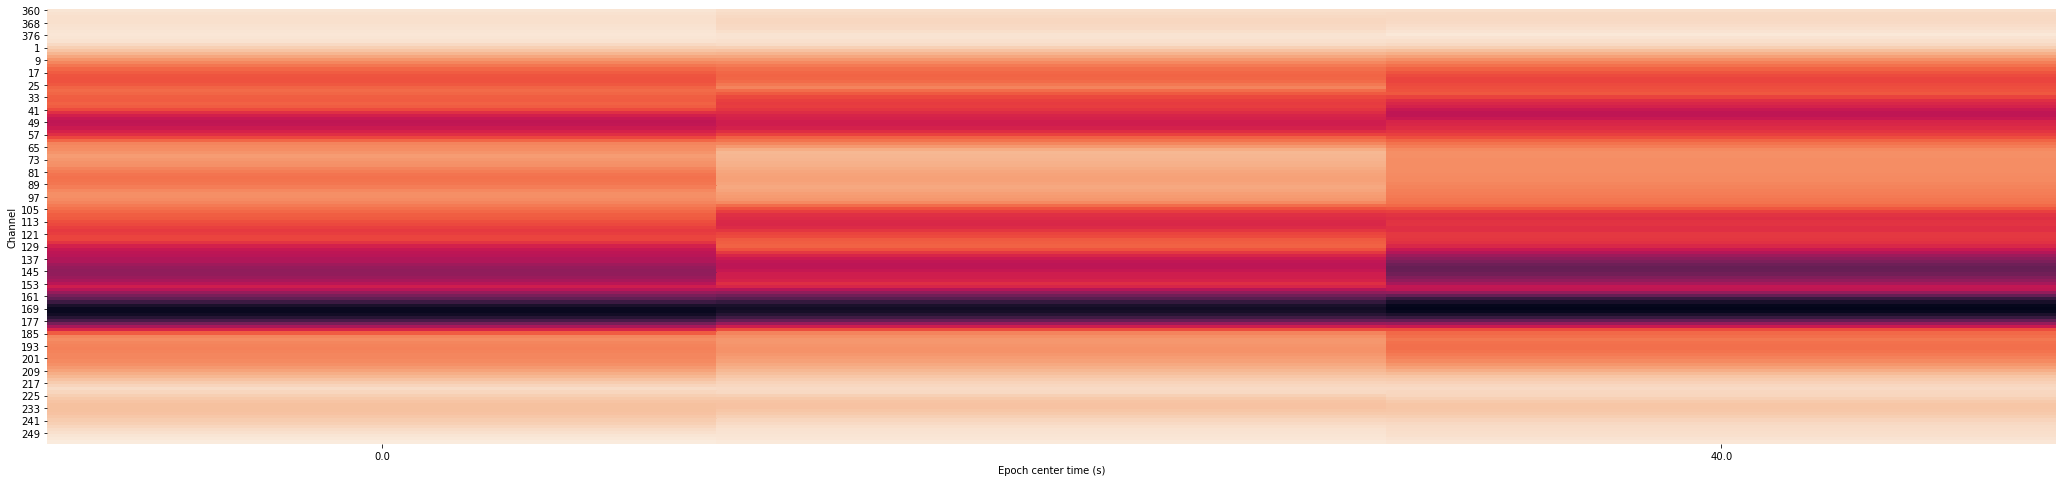

In [13]:
plot_epoched_csd_nadirs(epoched_csd_nadirs)

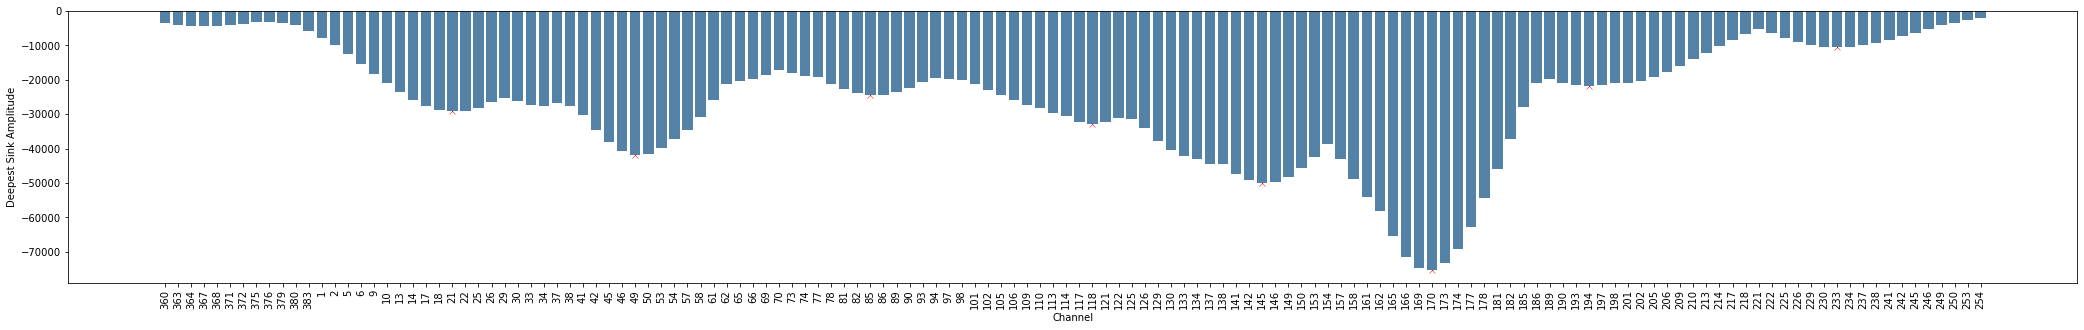

In [14]:
plot_csd_nadirs(epoched_csd_nadirs[:, 0])

In [19]:
epoched_csd_variance = csd.coarsen(time=int(epoch_length * csd.fs), coord_func={"time": "min"}, boundary='trim').var()

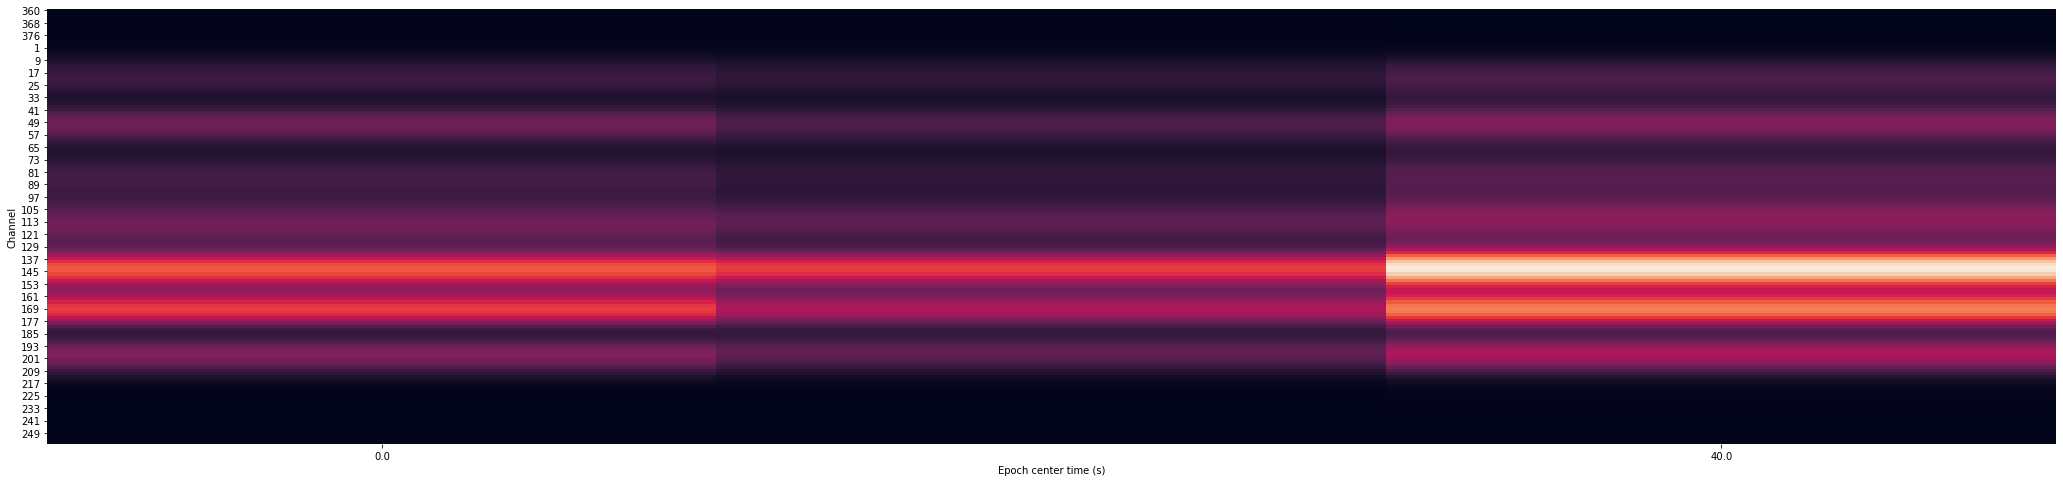

In [21]:
plot_epoched_csd_nadirs(epoched_csd_variance)

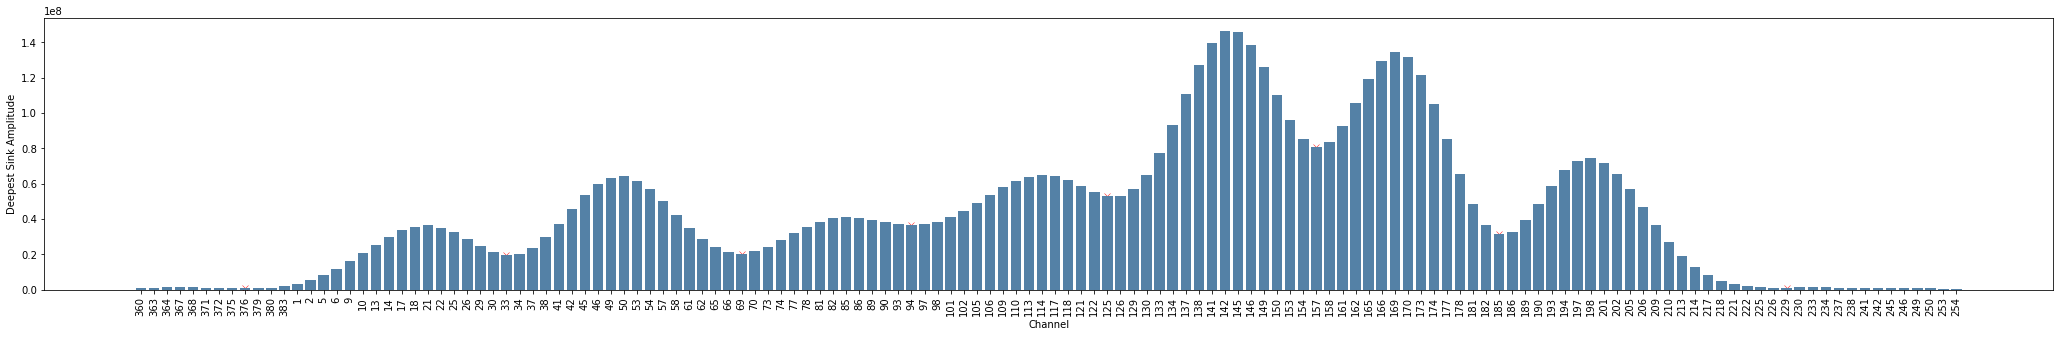

In [22]:
plot_csd_nadirs(epoched_csd_variance[:, 0])

In [64]:
previous = 170
i_previous = np.where(chans == guess)[0][0]
csd_nadirs = epoched_csd_nadirs[:, 0]
#def get_stratum_radiatum(guess, csd_nadirs):
peaks, _ = find_peaks(-csd_nadirs.values, prominence=1000, distance=10)   
i_new = find_nearest(peaks, i_previous)
new = chans[i_new]